# XAI notebook
Notebook defines way to test different CNN explainability techniques. This metric used masking and GAN to change the background of the given object in (classification) task.

In [1]:
import torch
import torchvision
import numpy as np
import cv2
from PIL import Image
from torchvision.datasets import VOCSegmentation, CIFAR10, Caltech101
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

## Load datasets and pretrained networks

In [3]:
from torchvision.models import resnet34, ResNet34_Weights

# Choose model
model_name = 'ResNet'

In [4]:
if model_name == 'ResNet':
    # Import only if model used
    from torchvision.models import resnet34, ResNet34_Weights
    
    # Loads best possible pre-trained weights for ImageNet dataset (further traning needed for other datasets)
    weights = ResNet34_Weights.DEFAULT
    # Init model with weights
    model = resnet34(weights=weights)

In [5]:
if model_name == 'DenseNet':
    # Import only if model used
    from torchvision.models import densenet121, DenseNet121_Weights

    # Loads best possible pre-trained weights for ImageNet dataset (further traning needed for other datasets)
    weights = DenseNet121_Weights.DEFAULT
    # Init model with weights
    model = densenet121(weights=weights)

In [6]:
root = 'C:/Users/pette/Documents/jupterNotebooks/machinelearning/datasets' # Own data root directory here

In [7]:
# Transforms for resnet and densenet. Output transform only needed for segmantation:
transform_input = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize(
         mean=[0.485, 0.456, 0.406],
         std=[0.229, 0.224, 0.225]
 )
])
transform_output = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
])


In [8]:
#voc_dataset = VOCSegmentation(root, year='2012', image_set='train', download=True, transform=transform_input, target_transform=transform_output)
#voc_original_dataset = VOCSegmentation(root, year='2012', image_set='train', download=True, transform=None, target_transform=None)
#dataset = Caltech101(root, download=True, transform=transform_input, target_transform=None)
#dataset_original = Caltech101(root, download=True, transform=None, target_transform=None)
dataset = CIFAR10(root, train=True, download=True, transform=transform_input, target_transform=None)
dataset_original = CIFAR10(root, train=True, download=True, transform=None, target_transform=None)
print(dataset_original[10])
print(dataset[10])

Files already downloaded and verified
Files already downloaded and verified
(<PIL.Image.Image image mode=RGB size=32x32 at 0x2D3C85648E0>, 4)
(tensor([[[-1.2103, -1.2103, -1.2103,  ..., -1.7069, -1.7069, -1.7069],
         [-1.2103, -1.2103, -1.2103,  ..., -1.7069, -1.7069, -1.7069],
         [-1.2103, -1.2103, -1.2103,  ..., -1.7069, -1.7069, -1.7069],
         ...,
         [-0.6623, -0.6623, -0.6623,  ..., -1.2788, -1.2788, -1.2788],
         [-0.6623, -0.6623, -0.6623,  ..., -1.2788, -1.2788, -1.2788],
         [-0.6623, -0.6623, -0.6623,  ..., -1.2788, -1.2788, -1.2788]],

        [[-0.8978, -0.8978, -0.8978,  ..., -1.5455, -1.5455, -1.5455],
         [-0.8978, -0.8978, -0.8978,  ..., -1.5455, -1.5455, -1.5455],
         [-0.8978, -0.8978, -0.8978,  ..., -1.5455, -1.5455, -1.5455],
         ...,
         [-0.5826, -0.5826, -0.5826,  ..., -1.1604, -1.1604, -1.1604],
         [-0.5826, -0.5826, -0.5826,  ..., -1.1604, -1.1604, -1.1604],
         [-0.5826, -0.5826, -0.5826,  ..., -1.

In [9]:
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=4)

## Train the model
Model can be further trained with loaded datasets. All classification models pretrained weights are trained on Imagenet dataset.

In [10]:
# Possibly add support for GPU

In [11]:
# Create optimizer and loss function
crit = torch.nn.CrossEntropyLoss()

momentum = 0
lr = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = momentum)

# Define number of epochs used for further training
epochs = 2
print(dataset[21])

(tensor([[[ 2.1975,  2.1975,  2.1975,  ...,  2.1804,  2.1804,  2.1804],
         [ 2.1975,  2.1975,  2.1975,  ...,  2.1804,  2.1804,  2.1804],
         [ 2.1975,  2.1975,  2.1975,  ...,  2.1804,  2.1804,  2.1804],
         ...,
         [ 1.9235,  1.9235,  1.9235,  ...,  2.1804,  2.1804,  2.1804],
         [ 1.9235,  1.9235,  1.9235,  ...,  2.1804,  2.1804,  2.1804],
         [ 1.9235,  1.9235,  1.9235,  ...,  2.1804,  2.1804,  2.1804]],

        [[-1.8957, -1.8957, -1.8957,  ..., -2.0182, -2.0182, -2.0182],
         [-1.8957, -1.8957, -1.8957,  ..., -2.0182, -2.0182, -2.0182],
         [-1.8957, -1.8957, -1.8957,  ..., -2.0182, -2.0182, -2.0182],
         ...,
         [-1.3880, -1.3880, -1.3880,  ..., -1.0203, -1.0203, -1.0203],
         [-1.3880, -1.3880, -1.3880,  ..., -1.0203, -1.0203, -1.0203],
         [-1.3880, -1.3880, -1.3880,  ..., -1.0203, -1.0203, -1.0203]],

        [[-1.0724, -1.0724, -1.0724,  ..., -1.2816, -1.2816, -1.2816],
         [-1.0724, -1.0724, -1.0724,  ..., -

In [12]:
for epoch in range(epochs):
    running_loss = 0
    for i, data in enumerate(data_loader, 0):
            inputs, labels = data[0], data[1]

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = crit(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            print(i)
    print(f"Loss in epoch {epoch}: {running_loss/(len(loader)*batch_size)}")

0
1
2
3
4
5
6
7
8
9
10


KeyboardInterrupt: 

# GradCAM example

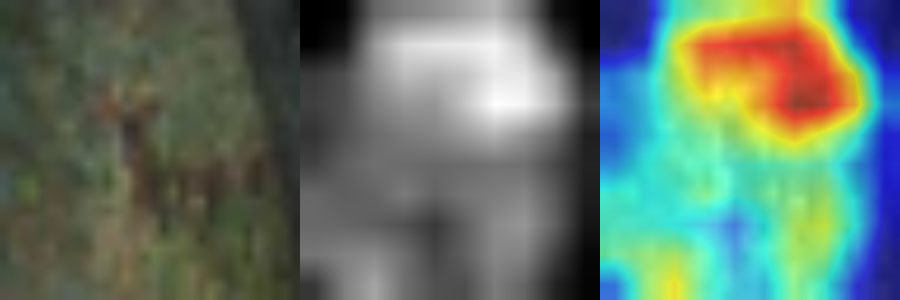

In [13]:
# Get transformed tensor with index
(input_tensor, label) = dataset[10]
# Get original image with index and reshape(for plotting)
(img, label) = dataset_original[10]
img = cv2.resize(np.array(img), (300, 300))
img = np.float32(img) / 255 # Assume 8 bit pixels


input_tensor = input_tensor.unsqueeze(0)

# Set target as our ground truth label
targets = [ClassifierOutputTarget(label)]
# Define target layer
target_layers = [model.layer4]

# Run model with given cam
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

# Make images the same format and plot original, greyscale and heatmap:
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)